# Tarea NLP

## Universidad de Valencia
## Máster de Inteligencia Artificial Avanzada y Aplicable

### Javier Cupeiro

# Problema de Clasificación Multietiqueta

Se trata de un problema de clasificación multietiqueta en el que tenéis que etiquetar un conjunto de tweets de acuerdo a 11 sentimientos:

- anger
- anticipation
- disgust
- fear
- joy
- love
- optimism
- pessimism
- sadness
- surprise
- trust

## Conjunto de Datos

Disponéis de un conjunto de 3561 tweets etiquetados para entrenar y validar el modelo o modelos necesarios, en el archivo `sem_eval_train_es.csv`.

Cada alumno tiene que validar sus modelos sobre el conjunto ciego de test con el nombre `sem_eval_test_blank_es.csv`. Cada Tweet tiene un ID (primera columna) que tenéis que mantener en vuestra solución. Debéis aplicar vuestro modelo entrenado a este conjunto y guardarlo en un archivo CSV de nombre `soluciones_nombre_apellido1_apellido2.csv`. El archivo CSV a entregar debe tener esta estructura de Pandas:

```plaintext
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
dtypes: bool(11), object(1)
Data columns (total 12 columns):
```
| #  | Column       | Non-Null Count | Dtype  |
|--- | ------       | -------------- | -----  |
| 0  | ID           | 679 non-null   | object |
| 1  | anger        | 679 non-null   | bool   |
| 2  | anticipation | 679 non-null   | bool   |
| 3  | disgust      | 679 non-null   | bool   |
| 4  | fear         | 679 non-null   | bool   |
| 5  | joy          | 679 non-null   | bool   |
| 6  | love         | 679 non-null   | bool   |
| 7  | optimism     | 679 non-null   | bool   |
| 8  | pessimism    | 679 non-null   | bool   |
| 9  | sadness      | 679 non-null   | bool   |
| 10 | surprise     | 679 non-null   | bool   |
| 11 | trust        | 679 non-null   | bool   |




Si el archivo no tiene exactamente esa estructura no se podrá evaluar.

## Entrega:

Cada alumno deberá entregar a través de esta tarea habilitada en AV el archivo CSV de las predicciones en el conjunto ciego de test y todo el código en Python utilizado tanto para el entrenamiento de los modelos como la inferencia en el conjunto ciego de test. El código Python se entregará como Notebook de Jupyter.

-----

In [1]:
# Librerías empleadas
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Configuramos semillas
SEMILLA = 33
random.seed(SEMILLA)
np.random.seed(SEMILLA)
tf.random.set_seed(SEMILLA)

---

### Empezamos cargando los datos, analizándolos, limpiarlos y prepararlos

In [5]:
# Cargamos datos
df_train = pd.read_csv('../data/sem_eval_train_es.csv')

# Dimensión
print(f"Dimensión: {df_train.shape}")

# Visualización del dataframe
df_train.sample(5)

Dimensión: (3561, 13)


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
645,2018-Es-02393,@MrkHdz El chiste es ayudar colega! En todos l...,False,False,False,False,True,False,True,False,False,False,False
995,2018-Es-06214,@Sebass_Psi Porque soy una persona responsable...,False,False,False,False,False,False,False,True,True,False,False
2300,2018-Es-03232,"@tom_feliu12 Una fan del DT, que a pesar de lo...",False,False,False,False,True,True,False,False,False,False,False
1534,2018-Es-04059,Estoy tan ansiosa con el estreno de Game of Th...,False,True,False,False,False,False,False,False,False,False,False
3480,2018-Es-03705,Es ver eso y romper en llanto😟,False,False,False,False,False,False,False,False,True,False,False


In [6]:
# Obtenemos información básica
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            3561 non-null   object
 1   Tweet         3561 non-null   object
 2   anger         3561 non-null   bool  
 3   anticipation  3561 non-null   bool  
 4   disgust       3561 non-null   bool  
 5   fear          3561 non-null   bool  
 6   joy           3561 non-null   bool  
 7   love          3561 non-null   bool  
 8   optimism      3561 non-null   bool  
 9   pessimism     3561 non-null   bool  
 10  sadness       3561 non-null   bool  
 11  surprise      3561 non-null   bool  
 12  trust         3561 non-null   bool  
dtypes: bool(11), object(2)
memory usage: 94.0+ KB


Se aprecia que todas las columnas están completas y no hay campos null.

Obtenemos ahora cuantas veces se encuentra cada sentimiento:

Conteo del número de veces que aparece cada sentimiento:
anger           1155
anticipation     415
disgust          521
fear             373
joy             1087
love             261
optimism         378
pessimism        578
sadness          845
surprise         169
trust            175
dtype: int64


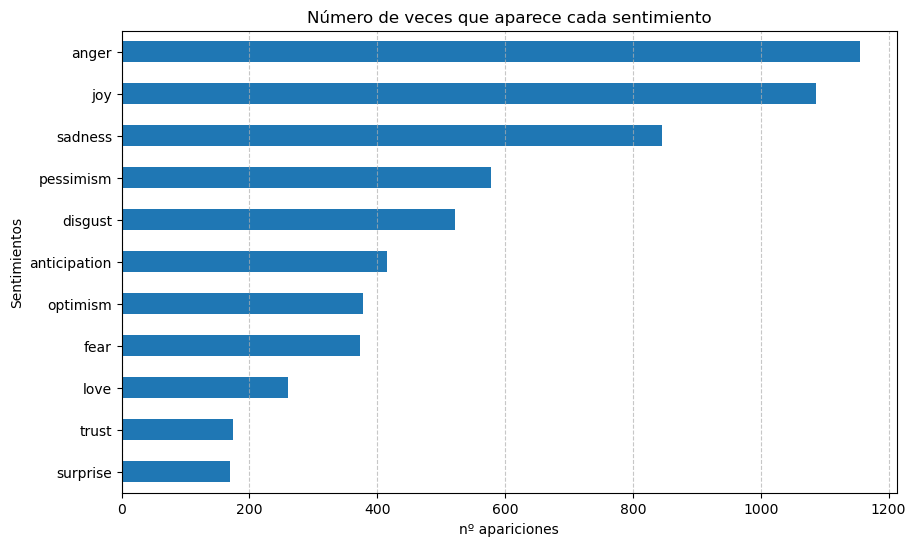

In [7]:
# Lista con todas las emociones
lista_emociones = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Obtenemos el número de veces que cada emoción es 'TRUE'
conteo_emociones = df_train[lista_emociones].sum()

print(f"Conteo del número de veces que aparece cada sentimiento:\n{conteo_emociones}")

# Gráfico
plt.figure(figsize=(10, 6))
conteo_emociones.sort_values().plot(kind='barh')
plt.xlabel('nº apariciones')
plt.ylabel('Sentimientos')
plt.title('Número de veces que aparece cada sentimiento')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Podemos ver que las emociones no están bien balanceadas ya que 'anger' y 'joy' aparecen mucho más que 'trust' y surprise. ¡Casi un orden de magnitud!

Lo ideal sería generar más tweets para balancear el número de apariciones de cada emoción pero disponemos de un dataset muy pequeño. 

---
### Limpieza 